# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = 'flower_data'
train_dir = 'flower_data/train'
valid_dir = 'flower_data/valid'

In [0]:
# Transformation
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) 

valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models

# VGG16 is used as pre-trained network
vgg16 = models.vgg16()
for param in vgg16.parameters():
    param.requires_grad = False


vgg16.classifier = nn.Sequential(nn.Linear(25088, 8200),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(8200, 2500),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(2500, 800),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(800, 102),
                                 nn.LogSoftmax(dim=1))

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.003)

import numpy as np

n_epochs = 30


valid_loss_min = np.Inf 
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    ###################
    # train the model #
    ###################
    vgg16.train() 
    for data, target in trainloader:
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16.forward(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg16.eval() # prep model for evaluation
    for data, target in validloader:
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the loss
        loss = criterion(output, target)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Training loss: {train_loss}")
    print(f"Validation Loss loss: {valid_loss}")
    print(f"Accuracy: {accuracy}")
    print("--------------------")
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        vgg16.class_to_idx = train_dataset.class_to_idx
        checkpoint = {'input_size': 25088,
              'output_size': 102,
              'hidden_layers': [8200, 2500, 800],
              'state_dict': vgg16.state_dict()}
        torch.save(checkpoint, 'checkpoint.pth')
        valid_loss_min = valid_loss

Training loss: 5.406314242599357
Validation Loss loss: 4.535550832165483
Accuracy: 0.7118055820465088
--------------------
Validation loss decreased (inf --> 4.535551).  Saving model ...


In [0]:
# Loading the saved model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    vgg16.load_state_dict(checkpoint['state_dict'])
    return vgg16
  

model = load_checkpoint('checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
from PIL import Image
import numpy as np
def process_image(image):
    
    img = Image.open(image)
    img = valid_transforms(img)
    return  np.array(img)
    



In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

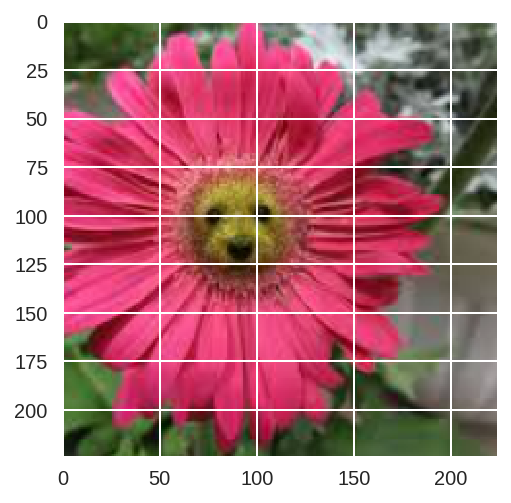

In [0]:
img = process_image('flower.jpg')
img = imshow(img)

In [0]:
# To process image in required format
def process(image):
    img = Image.open(image)
    return valid_transforms(img).unsqueeze(0) # unsqueeze is used to extend the dimension

In [0]:
# Prediction function to predict specie
def predict(image_path, model, topk=5):
    img = process(image_path)
    output = model(img)
    ps = torch.exp(output)/torch.sum(torch.exp(output))
    return ps.topk(topk, dim=1)

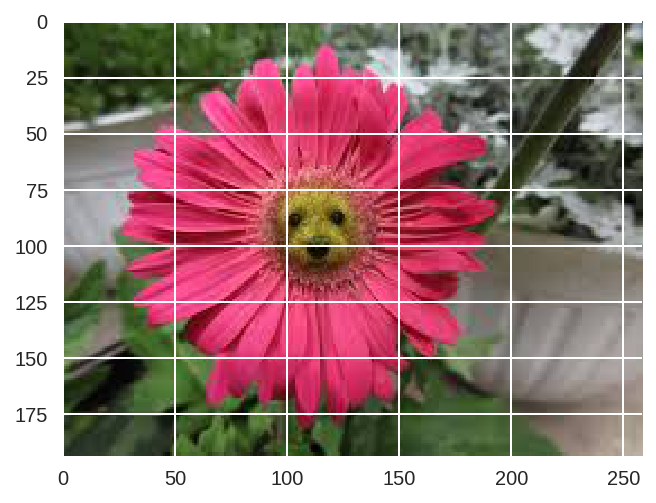

In [57]:
import matplotlib.image as mpimg
img = mpimg.imread('flower.jpg')
plt.imshow(img)

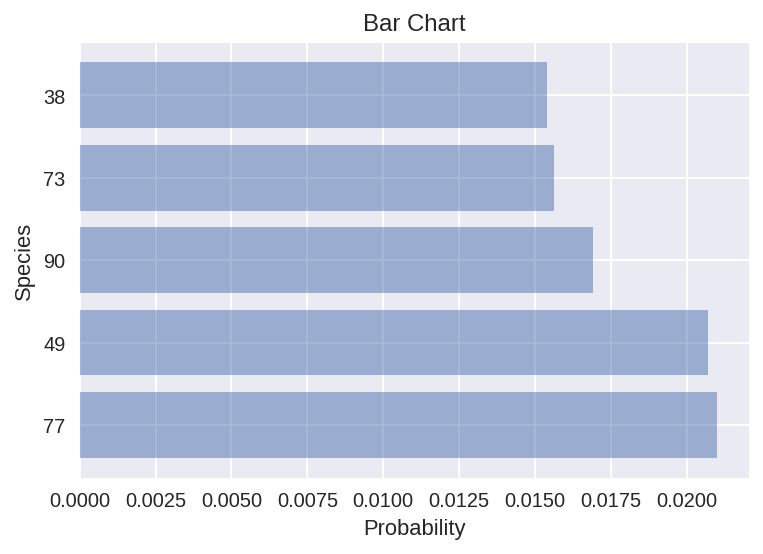

In [58]:
topp,topc = predict('flower.jpg', model)

classes = topc.numpy().squeeze()
prob = topp.detach().numpy().squeeze()
y_pos = np.arange(len(classes))

plt.barh(y_pos, prob, align='center', alpha=0.5)
plt.yticks(y_pos, classes)
plt.ylabel('Species')
plt.xlabel('Probability')
plt.title('Bar Chart')
plt.show()